In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/')
from func.vis import vis as vis
import nibabel as nib
from skimage.transform import resize

sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/')
from dataloader import test_dataloader, npy_train_loader
from models import unet512
import yaml
import random
import torch
from monai.utils import set_determinism
from monai.metrics import DiceMetric

/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_id = "0907_TS"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
model_dir = os.path.join(config["model_dir"], config_id)
device = torch.device("cuda:0")


In [21]:
from monai.transforms import Compose, LoadImaged, AddChanneld, Spacingd, Orientationd, ScaleIntensityRanged, EnsureTyped
from monai.data import DataLoader, Dataset

def infer_dataloader(config, val_images):
    test_transforms = Compose([
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Spacingd(keys=["image"], pixdim=config["pix_dim"], mode=("bilinear")),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=config["window"][0], a_max=config["window"][1], b_min=0.0, b_max=1.0,
                            clip=True),
        EnsureTyped(keys=["image"]),
    ])
    if config["dataset"] == "vlsp":
        val_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in val_images]
    elif config["dataset"] == "TS":
        val_file_names = [os.path.basename(name) for name in val_images]
    elif config["dataset"] == "luna16":
        val_file_names = [f"{os.path.basename(name)[:-4]}_LobeSegmentation.nrrd" for name in val_images]
    elif config["dataset"] == "mixed":
        val_file_names = []
        for i in val_images:
            name, suffix = os.path.splitext(os.path.basename(i))
            if suffix == ".mhd":
                val_file_names.append(f"{name}_LobeSegmentation.nrrd")
            elif suffix == ".gz":
                fname = f"{name[:-4]}_LobeSegmentation.nii.gz" if name[1] == '.' else f"{name[:-4]}_lvlsetseg.nii.gz"
                val_file_names.append(fname)
    else:
        print("Error: define dataset in Config.YAML")
        return
    val_files = [
        {"image": image_name, "image_path": image_name}
        for image_name in val_images
    ]
    infer_ds = Dataset(data=val_files, transform=test_transforms)
    infer_loader = DataLoader(infer_ds, batch_size=1, num_workers=config["num_workers"], shuffle=False)
    return infer_loader


In [45]:


data_dir = config["test_dir"]
images = glob.glob(os.path.join(data_dir, "*.nii.gz"))[0]
infer_loader = infer_dataloader(config, [images])
model = unet512(6).to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, f"{config_id}_best_model.pth")))
test_metric = DiceMetric(include_background=False, reduction="none")

In [46]:

import torch
import nibabel as nib
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference
from monai.transforms import (
    Compose,
    AsDiscrete,
    EnsureType,
    AsDiscrete,
    Spacing,
    Resize,
    Orientation,
    AddChannel
)
from postprocess import get_largest_cc, lungmask_filling
import math

def infer(device, model, infer_loader):
    model.eval()
    
    with torch.no_grad():
        for batch in infer_loader:
            data, image_path = batch["image"].to(device), batch["image_path"][0]
            fname = os.path.basename(image_path).split(".")[0]
            
            raw_nii = nib.load(image_path)
            axcodes = nib.orientations.aff2axcodes(raw_nii.affine)
            axcodes = ''.join(axcodes)
            pixdim = raw_nii.header.get_zooms()
            spatial_size = raw_nii.shape
            print(spatial_size)
            # skip if volume exceeds VRAM constraints
            if math.prod(spatial_size) > 768*768*500:
                continue
            post_pred_transforms = Compose([
                EnsureType(),
                AsDiscrete(argmax=True),
                Orientation(axcodes=axcodes),
                Spacing(pixdim=pixdim, mode="nearest"), 
                Resize(spatial_size=spatial_size, mode="nearest"),
            ])
            pred = sliding_window_inference(data, config["crop_shape"], 4, model)
            pred = post_pred_transforms(pred[0])
            label_map = pred[0].detach().cpu().numpy()
            label_map = lungmask_filling(get_largest_cc(label_map), image_path)
    return image_path, label_map

In [47]:
image_path, seg = infer(device, model, infer_loader)
raw = nib.load(image_path).get_fdata()



(512, 512, 293)


100%|██████████| 2/2 [00:00<00:00, 334.75it/s]


(512, 512, 411)


100%|██████████| 3/3 [00:00<00:00, 221.42it/s]


In [60]:
label_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_al/label"
label = nib.load(os.path.join(label_dir, f"{os.path.basename(image_path).split('.nii.gz')[0]}_LobeSegmentation.nii.gz")).get_fdata()

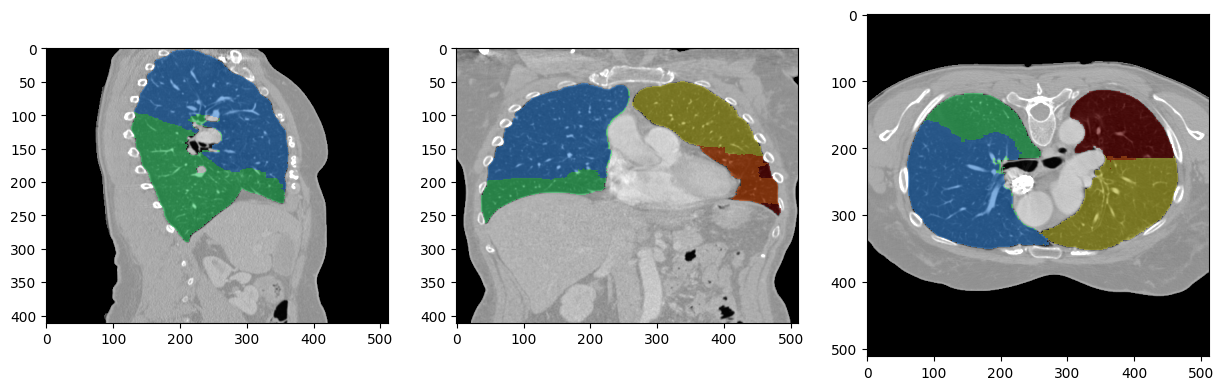

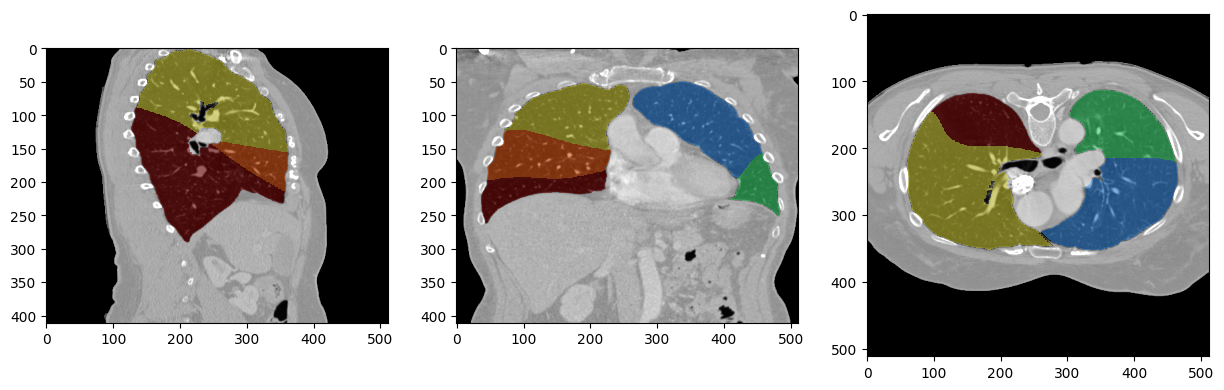

In [61]:
xyz = [200,200,300]
vis.vis_overlay_slices(raw, seg, xyz, orientation="LAS", cmap="turbo")
vis.vis_overlay_slices(raw, label, xyz, orientation="LAS", cmap="turbo")

In [137]:
from monai.transforms import (
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    AddChanneld,
    RandShiftIntensityd,
    RandAffined,
    ToTensord,
    EnsureTyped,
    SpatialPadd,
    SpatialPad,
    Flipd,
)
from monai.data import DataLoader, Dataset
import numpy as np
import os
from skimage.transform import resize
def train_dataloader(config, train_images):
    LABEL_DIR = config["label_dir"]

    # get labels from vlsp
    if config["dataset"] == "vlsp":
        train_file_names = [f"lvlsetseg_{os.path.basename(name)}" for name in train_images]
    elif config["dataset"] == "TS":
        train_file_names = [os.path.basename(name) for name in train_images]
    elif config["dataset"] == "luna16":
        train_file_names = [f"{os.path.basename(name)[:-4]}_LobeSegmentation.nrrd" for name in train_images]
    elif config["dataset"] == "mixed":
        train_file_names = []
        for i in train_images:
            name, suffix = os.path.splitext(os.path.basename(i))
            if suffix == ".mhd":
                train_file_names.append(f"{name}_LobeSegmentation.nrrd")
            elif suffix == ".gz":
                fname = f"{name[:-4]}_LobeSegmentation.nii.gz" if name[1] == '.' else f"{name[:-4]}_lvlsetseg.nii.gz"
                train_file_names.append(fname)
    else:
        print("Error: define dataset in Config.YAML")
        return
    train_labels = [os.path.join(LABEL_DIR, name) for name in train_file_names]
    train_files = [
        {"image": image_name, "label": label_name, "image_path": image_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
    # val_size = int(len(train_images)*config["val_ratio"])
    # train_files, val_files = data_dicts[:-val_size], data_dicts[-val_size:]

    set_determinism(seed=config["random_seed"])

    # Hyperparams and constants
    BATCH_SIZE = config["batch_size"]
    CROP_SHAPE = config["crop_shape"] # produce 4 crops of this size from raw image

    # Transforms
    hu_window = config["window"] # lung Hounsfield Unit window
    if config["dataset"]=="TS":
        train_transforms = Compose([
            LoadImaged(keys=["image", "label"]),
            # EnsureChannelFirstd(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=config["pix_dim"], mode=("bilinear", "nearest")),
            MatchSized(keys=["image", "label"], mode="crop"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Flipd(keys=["image", "label"], spatial_axis=0),
            ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0,
                                clip=True),
            SpatialPadd(keys=["image", "label"], spatial_size=CROP_SHAPE),
        ])
    else:
        train_transforms = Compose([
            LoadImaged(keys=["image", "label"]),
            # EnsureChannelFirstd(keys=["image", "label"]),
            AddChanneld(keys=["image", "label"]),
            Spacingd(keys=["image", "label"], pixdim=config["pix_dim"], mode=("bilinear", "nearest")),
            MatchSized(keys=["image", "label"], mode="crop"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["image"], a_min=hu_window[0], a_max=hu_window[1], b_min=0.0, b_max=1.0,
                                clip=True),
            SpatialPadd(keys=["image", "label"], spatial_size=CROP_SHAPE),
        ])
    # Initialize Dataset
    train_ds = Dataset(data=train_files, transform=train_transforms)
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                            num_workers=config["num_workers"], pin_memory=True)

    print(f"Training sample size: {len(train_ds)}")

    return train_loader

class MatchSized(object):
    """Resize input A to match size of input B"""
    def __init__(self, keys, mode="interp"):
        self.keyA, self.keyB = keys[0], keys[1]
        self.mode = mode
    
    def __call__(self, data):
        a, b = data[self.keyA], data[self.keyB]
        if a.shape != b.shape:
            if self.mode=="interp":
                a = resize(a, b.shape)
            else:
                # crop then pad
                a = a[..., :b.shape[-3], :b.shape[-2], :b.shape[-1]]
                pad = SpatialPad(b.shape[-3:])
                a = pad(a)
        # assert (math.prod(a.shape) > 96**3), "less than (96,96,96) patch shape"
        assert (a.shape==b.shape), f"resizing failed: data are not same shape! {data['image_path']}: {a.shape}, {b.shape}"
        return {self.keyA: a, self.keyB: b}

In [3]:
import os
import glob
from monai.utils import set_determinism
# from dataloader import npy_train_loader
# def load_config(config_name, config_dir):
#     with open(os.path.join(config_dir, config_name)) as file:
#         config = yaml.load(file, Loader=yaml.FullLoader)
#     return config

CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_TS = load_config(f"Config_0909_TS.YAML", CONFIG_DIR)
config_vlsp = load_config("Config_0416unet512peter.YAML", CONFIG_DIR)

images_TS = glob.glob(os.path.join(config_TS["data_dir"], "*.npy"))[:5]
images_vlsp = glob.glob(os.path.join(config_vlsp["data_dir"], "*.nii.gz"))[:5]

TS_loader = npy_train_loader(config_TS, images_TS)
# vlsp_loader = npy_train_loader(config_vlsp, images_vlsp)


In [4]:
images_TS

['/home/litz/data/TotalSegmentator/dataset/npy/train/s0369.npy',
 '/home/litz/data/TotalSegmentator/dataset/npy/train/s0594.npy',
 '/home/litz/data/TotalSegmentator/dataset/npy/train/s0528.npy',
 '/home/litz/data/TotalSegmentator/dataset/npy/train/s0791.npy',
 '/home/litz/data/TotalSegmentator/dataset/npy/train/s0224.npy']

In [5]:
# fix orientation
batch_TS = next(iter(TS_loader))
# batch_vlsp = next(iter(vlsp_loader))

data_TS, label_TS = batch_TS["image"][0, 0], batch_TS["label"][0, 0]

print(data_TS.shape)
# data_vlsp, label_vlsp = batch_vlsp["image"][0,0], batch_vlsp["label"][0,0]
# data_TS = np.flip(data_TS, 0)
# label_TS = np.flip(label_TS, 0)


> collate dict key "image" out of 4 keys
>> collate/stack a list of tensors
>> E: stack expects each tensor to be equal size, but got [1, 278, 214, 181] at entry 0 and [1, 260, 212, 220] at entry 1, shape [(1, 278, 214, 181), (1, 260, 212, 220), (1, 186, 175, 223), (1, 274, 196, 196), (1, 258, 196, 266)] in collate([tensor([[[[7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 7.5166e-08,
           7.5166e-08, 7.5166e-08],
          [7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 7.5166e-08,
           7.5166e-08, 7.5166e-08],
          [7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 4.5701e-05,
           7.5166e-08, 7.5166e-08],
          ...,
          [7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 9.1290e-05,
           9.1290e-05, 7.5166e-08],
          [7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 7.5166e-08,
           7.5166e-08, 7.5166e-08],
          [7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 7.5166e-08,
           7.5166e-08, 7.5166e-08]],

         [[7.5166e-08, 7.5166e-08, 7.5166e-08,  ..., 7.5166

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/monai/data/utils.py", line 464, in list_data_collate
    ret[key] = collate_meta_tensor(data_for_batch)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/monai/data/utils.py", line 429, in collate_meta_tensor
    collated = default_collate(batch)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/torch/utils/data/_utils/collate.py", line 141, in default_collate
    return torch.stack(batch, 0, out=out)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/monai/data/meta_tensor.py", line 245, in __torch_function__
    ret = super().__torch_function__(func, types, args, kwargs)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/torch/_tensor.py", line 1121, in __torch_function__
    ret = func(*args, **kwargs)
RuntimeError: stack expects each tensor to be equal size, but got [1, 278, 214, 181] at entry 0 and [1, 260, 212, 220] at entry 1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home-nfs2/local/VANDERBILT/litz/github/MASILab/lobe_seg/env/lib/python3.8/site-packages/monai/data/utils.py", line 479, in list_data_collate
    raise RuntimeError(re_str) from re
RuntimeError: stack expects each tensor to be equal size, but got [1, 278, 214, 181] at entry 0 and [1, 260, 212, 220] at entry 1
Collate error on the key 'image' of dictionary data.

MONAI hint: if your transforms intentionally create images of different shapes, creating your `DataLoader` with `collate_fn=pad_list_data_collate` might solve this problem (check its documentation).


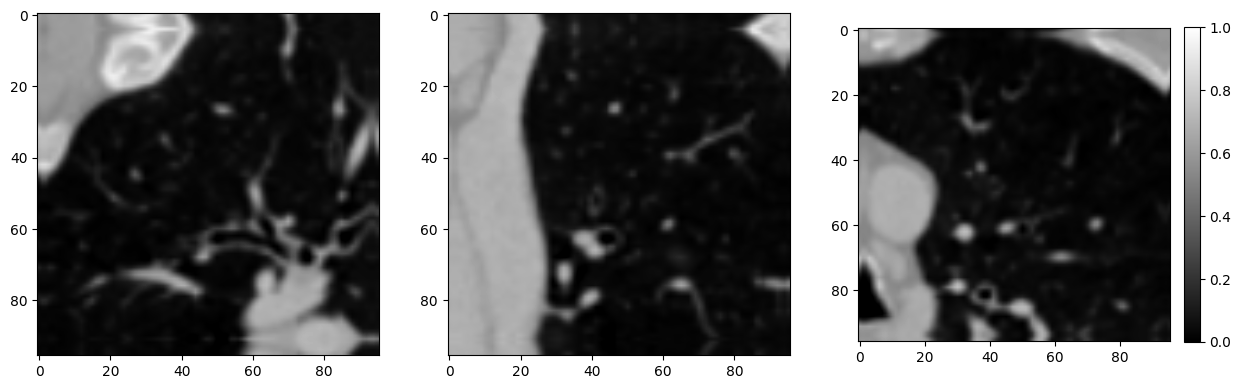

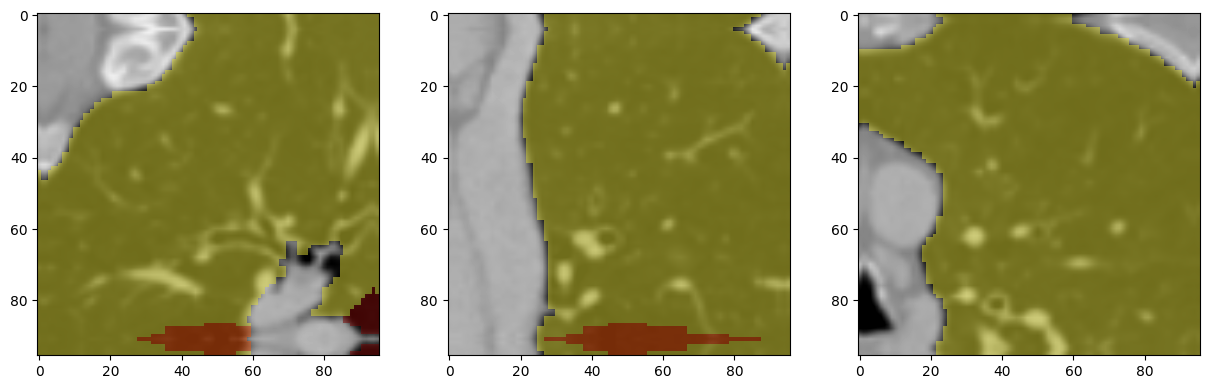

In [8]:
xyz = [45,45,45]
vis.vis_slices(data_TS, xyz,  orientation="LAS", clip_range=[0,1])
vis.vis_overlay_slices(data_TS, label_TS, xyz, orientation="LAS", cmap="turbo", clip_range=[0,1])
xyz = [150,200,100]
# vis.vis_slices(data_vlsp, xyz,  orientation="LAS", clip_range=[0,1])
# vis.vis_overlay_slices(data_vlsp, label_vlsp, xyz, orientation="LAS", cmap="turbo", clip_range=[0,1])

In [6]:
ts_raw_dir = "/home/litz/data/TotalSegmentator/dataset/npy/train"
ts_label_dir = "/home/litz/data/TotalSegmentator/dataset/npy/label"
vlsp_raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/train_preproc/"
vlsp_label_dir = "/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/"

In [17]:
ts_scanid = "s0362.npy"
ts_raw = np.load(os.path.join(ts_raw_dir, ts_scanid))[0]
# ts_raw_img = ts_raw.get_fdata()
ts_label = np.load(os.path.join(ts_label_dir, ts_scanid))[0]
# ts_label_img = ts_label.get_fdata()
vlsp_scanid = "00000582time20170403"
vlsp_raw = nib.load(os.path.join(vlsp_raw_dir, f"{vlsp_scanid}.nii.gz"))
vlsp_raw_img = vlsp_raw.get_fdata()
vlsp_label = nib.load(os.path.join(vlsp_label_dir, f"lvlsetseg_{vlsp_scanid}.nii.gz"))
vlsp_label_img = vlsp_label.get_fdata()

In [18]:
ts_raw.shape

(296, 216, 266)

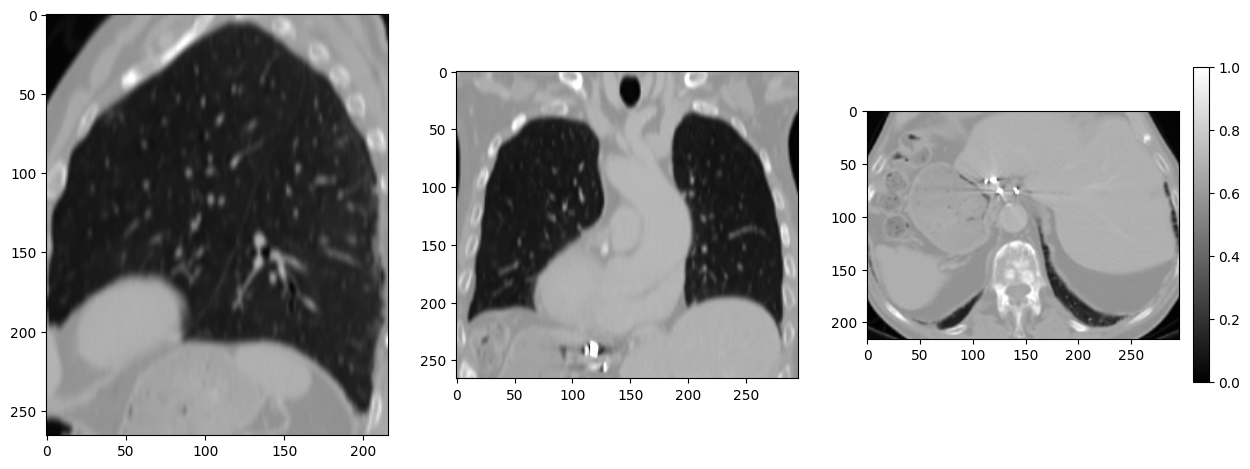

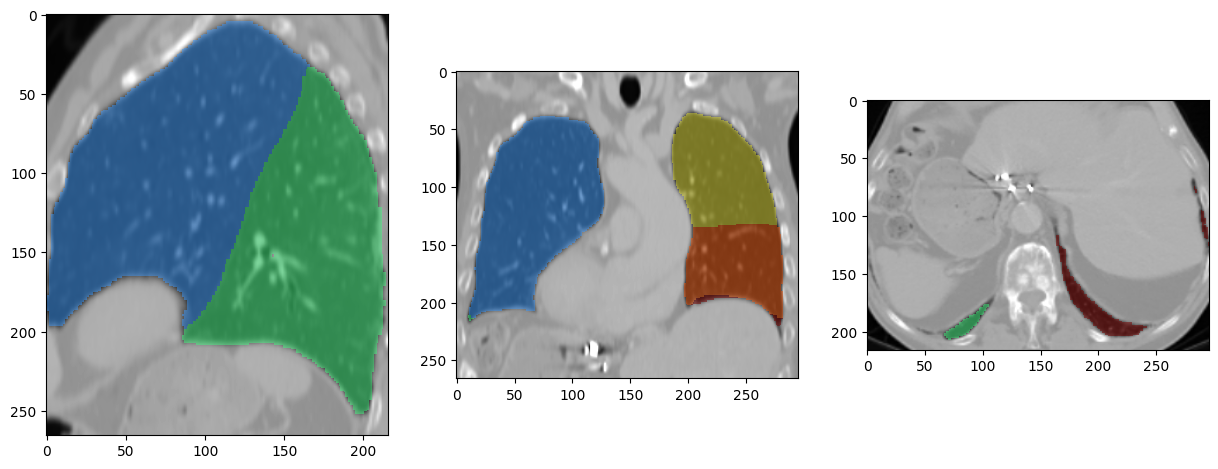

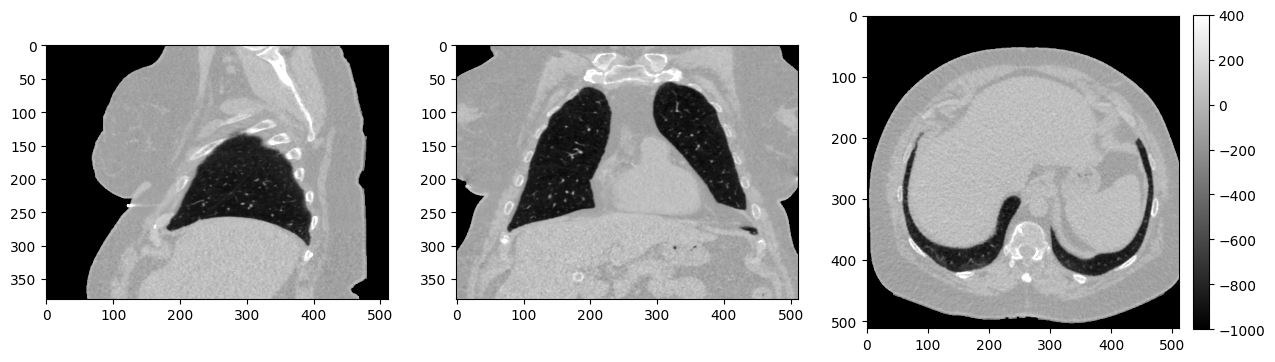

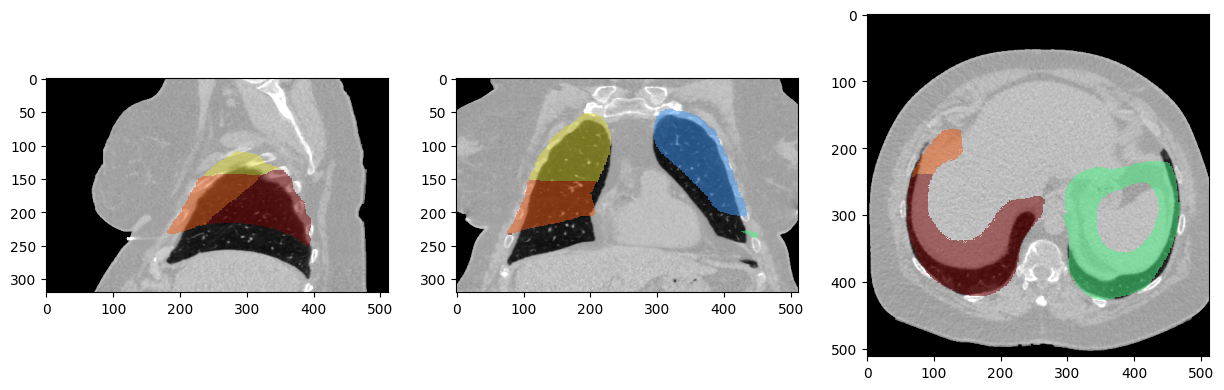

In [21]:
xyz = [80, 150,20]
vis.vis_slices(ts_raw, xyz,  orientation="LAS", clip_range=[0,1])
vis.vis_overlay_slices(ts_raw, ts_label, xyz, orientation="LAS", cmap="turbo", clip_range=[0,1])
xyz = [100,300,100]
vis.vis_slices(vlsp_raw_img, xyz,  orientation="LAS", clip_range=[-1000, 400])
vis.vis_overlay_slices(vlsp_raw_img, vlsp_label_img, xyz, orientation="LAS", cmap="turbo", clip_range=[-1000, 400])

In [132]:
print(ts_raw.affine)


[[ 1.49719143e+00  8.81885365e-02  2.58967821e-02 -1.98649384e+02]
 [-8.80033225e-02  1.49740541e+00 -1.52218528e-03  2.86901035e+01]
 [-2.59414781e-02  0.00000000e+00  1.49977565e+00  1.31171967e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [133]:
print(vlsp_raw.affine)

[[  -0.66601562   -0.            0.          179.36599731]
 [   0.            0.66601562    0.         -277.13397217]
 [   0.            0.            0.80000114 -322.01043701]
 [   0.            0.            0.            1.        ]]
